In [1]:
# 1. 필수 라이브러리 임포트

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import VGG19

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


In [2]:
# 2. 데이터 준비
import os

def load_and_preprocess_image(path, size=(256, 256)):
    img = Image.open(path).convert('L').resize(size, Image.LANCZOS)
    return np.array(img, dtype=np.float32) / 255.0

image_paths = ['starry_night.jpg', 'mona_lisa.jpg']
if not all(os.path.exists(p) for p in image_paths):
    print("Error: Image files not found.")
    exit()

original_images = [load_and_preprocess_image(p) for p in image_paths]
original_labels = [0, 1] # 0: 별이 빛나는 밤, 1: 모나리자
class_names = ["Starry Night", "Mona Lisa"]
print("Artworks loaded successfully!")

def add_noise_snr_np(image, snr_db):
    signal_power = np.var(image)
    snr_linear = 10 ** (snr_db / 10.0)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1).astype(np.float32)

Artworks loaded successfully!


In [3]:
# 3. 데이터 셋 
def create_multitask_datasets(images, labels, samples_per_snr=50):
    X_data, y_restore, y_classify = [], [], []
    snr_x_levels = [-10, -20, -30]
    snr_y_level = 0
    
    total_samples = len(images) * len(snr_x_levels) * samples_per_snr
    print(f"Generating {total_samples} data samples...")
    
    for img, label in zip(images, labels):
        target_img = add_noise_snr_np(img, snr_y_level)
        for snr in snr_x_levels:
            for _ in range(samples_per_snr):
                noisy_img = add_noise_snr_np(img, snr)
                X_data.append(noisy_img)
                y_restore.append(target_img)
                y_classify.append(label)

    X_data = np.array(X_data)[..., np.newaxis]
    y_restore = np.array(y_restore)[..., np.newaxis]
    y_classify = np.array(y_classify)
    
    # Keras가 다중 출력을 다루기 쉽도록 y 데이터를 딕셔너리 형태로 만듭니다.
    y_data_dict = {
        "restoration_output": y_restore,
        "classification_output": y_classify
    }
    
    return X_data, y_data_dict

# SNR 레벨당 10개씩, 총 2 * 3 * 10 = 60개의 데이터 샘플 생성
X_data, y_data = create_multitask_datasets(original_images, original_labels, samples_per_snr=10)

print(f"Input data shape: X={X_data.shape}")
print(f"Restore target shape: y={y_data['restoration_output'].shape}")
print(f"Classify target shape: y={y_data['classification_output'].shape}")
print("-" * 30)

Generating 60 data samples...
Input data shape: X=(60, 256, 256, 1)
Restore target shape: y=(60, 256, 256, 1)
Classify target shape: y=(60,)
------------------------------


In [ ]:
# 4. 모델 설계  
from tensorflow.keras import layers, Model

def build_lightweight_multitask_unet(input_shape, num_classes):
    def conv_block(input_tensor, num_filters):
        x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(input_tensor)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(num_filters, 3, padding='same', kernel_initializer='he_normal')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x

    def decoder_block(input_tensor, skip_tensor, num_filters):
        x = layers.Conv2DTranspose(num_filters, 2, strides=2, padding='same')(input_tensor)
        x = layers.concatenate([x, skip_tensor])
        x = conv_block(x, num_filters)
        return x

    inputs = layers.Input(shape=input_shape)
    
    # Encoder (필터 수를 줄여 경량화)
    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D(2)(c1)
    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D(2)(c2)
    c3 = conv_block(p2, 64)
    p3 = layers.MaxPooling2D(2)(c3)
    
    # Bottleneck
    b = conv_block(p3, 128)
    
    # Decoder
    d3 = decoder_block(b, c3, 64)
    d2 = decoder_block(d3, c2, 32)
    d1 = decoder_block(d2, c1, 16)
    restoration_head = layers.Conv2D(1, 1, activation='sigmoid', name="restoration_output")(d1)
    
    # Classification Head (유닛 수 감소)
    flat = layers.GlobalAveragePooling2D()(b)
    dense1 = layers.Dense(64, activation='relu')(flat)
    dropout = layers.Dropout(0.5)(dense1)
    classification_head = layers.Dense(num_classes, activation='softmax', name="classification_output")(dropout)
    
    model = Model(inputs=inputs, outputs=[restoration_head, classification_head])
    return model

In [ ]:
# ==============================================================================
# 5. 모델 컴파일 및 학습 (최종 안정화 버전)
# ==============================================================================
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# --- 5-1. 모델 생성 (경량 모델 사용) ---
model = build_lightweight_multitask_unet(input_shape=(256, 256, 1), num_classes=2)

# --- 5-2. 학습률 스케줄러 및 콜백 정의 ---
initial_learning_rate = 5e-4
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=True)

checkpoint_filepath = 'best_model_baseline.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50, verbose=1, restore_best_weights=False)

# --- 5-3. 모델 컴파일 (단순하고 강력한 손실 함수) ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={
        "restoration_output": "mean_squared_error",
        "classification_output": "sparse_categorical_crossentropy"
    },
    loss_weights={
        "restoration_output": 1.0,
        "classification_output": 1.0
    },
    metrics={"classification_output": "accuracy"}
)
model.summary()

# --- 5-4. 모델 학습 ---
print("\n--- Training Baseline Multi-task Model ---")
history = model.fit(
    X_data,
    y_data,
    epochs=500,
    batch_size=16,
    shuffle=True,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

2025-09-12 15:04:57.118341: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-09-12 15:04:57.118360: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-12 15:04:57.118366: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-12 15:04:57.118389: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-12 15:04:57.118404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



--- Training with model.fit() and Callbacks ---
Epoch 1/1000


2025-09-12 15:04:59.174398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-09-12 15:04:59.344506: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


3/3 [==============================] - 5s 1s/step - loss: 1.2263 - content_loss: 0.1711 - perceptual_loss: 9.1169 - classification_loss: 1.0097 - accuracy: 0.5208 - val_loss: 0.8702 - val_content_loss: 0.0974 - val_perceptual_loss: 10.8426 - val_classification_loss: 0.7186 - val_accuracy: 0.0000e+00
Epoch 2/1000
3/3 [==============================] - 2s 660ms/step - loss: 0.9380 - content_loss: 0.1601 - perceptual_loss: 8.8223 - classification_loss: 0.7338 - accuracy: 0.6458 - val_loss: 0.8577 - val_content_loss: 0.0985 - val_perceptual_loss: 10.8759 - val_classification_loss: 0.7048 - val_accuracy: 0.0000e+00
Epoch 3/1000
3/3 [==============================] - 2s 652ms/step - loss: 0.6834 - content_loss: 0.1515 - perceptual_loss: 8.6907 - classification_loss: 0.4885 - accuracy: 0.6875 - val_loss: 0.8551 - val_content_loss: 0.0994 - val_perceptual_loss: 10.9267 - val_classification_loss: 0.7011 - val_accuracy: 0.0000e+00
Epoch 4/1000
3/3 [==============================] - 2s 619ms/step

--- Final Training Metrics (at last epoch) ---
Final Total Training Loss: 0.085134
Final Total Validation Loss: 14.522906
Final Validation Accuracy: 0.00%
------------------------------


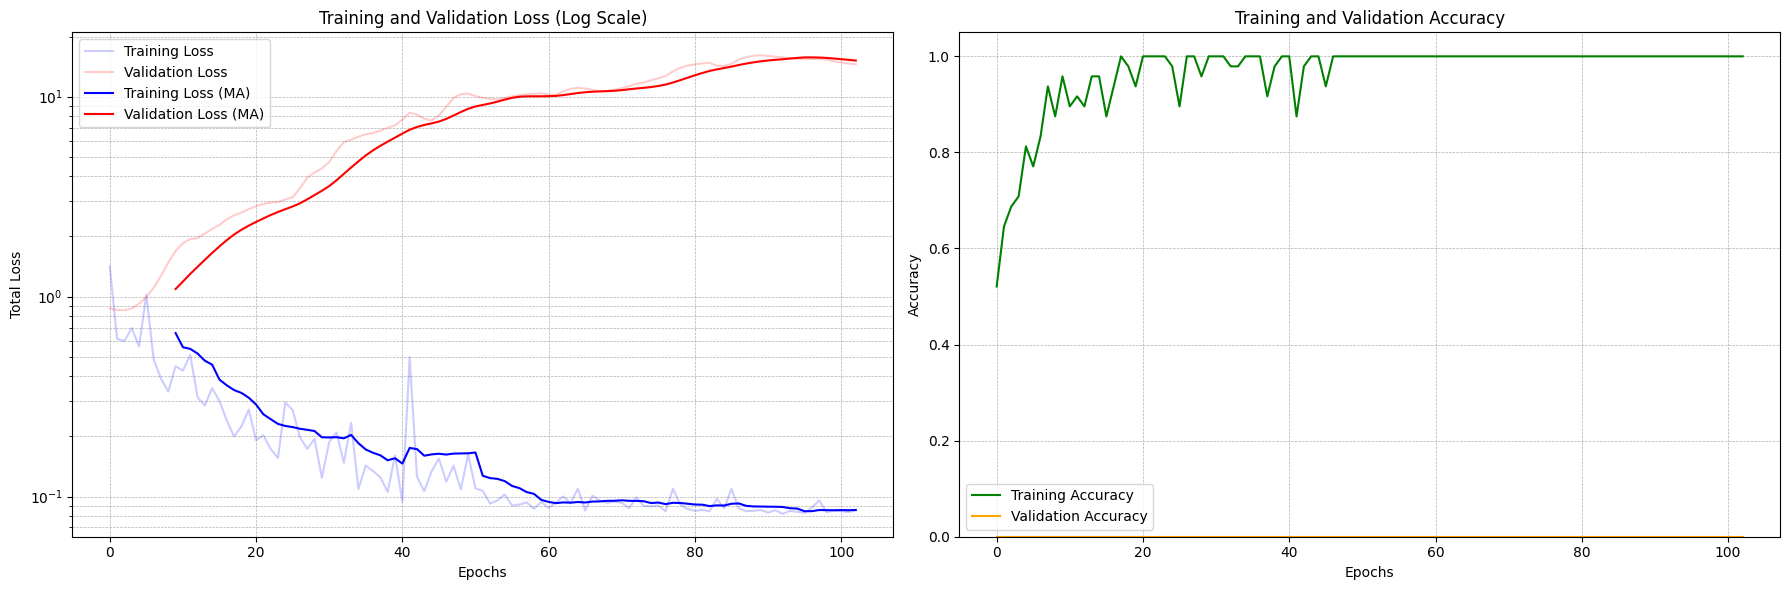

------------------------------


In [6]:
# ==============================================================================
# 6. 로스 시각화 (최종 수정 버전)
# ==============================================================================

# --- 최종 Loss 출력 (history.history로 접근하고 .numpy() 제거) ---
# model.fit()이 반환한 History 객체 내부의 .history 딕셔너리에 접근합니다.
final_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
# 'accuracy' 메트릭의 이름은 history.history.keys()로 확인 가능합니다. 보통 'accuracy' 입니다.
final_accuracy = history.history['val_accuracy'][-1]

print("--- Final Training Metrics (at last epoch) ---")
print(f"Final Total Training Loss: {final_loss:.6f}")
print(f"Final Total Validation Loss: {final_val_loss:.6f}")
print(f"Final Validation Accuracy: {final_accuracy*100:.2f}%")
print("-" * 30)


# --- 학습 그래프 시각화 함수 ---
# 이 함수는 이미 history.history를 올바르게 사용하고 있었으므로 수정할 필요가 없습니다.
def plot_history(history_obj, window_size=10): # 변수 이름을 history_obj로 명확하게 변경
    # --- 1. Loss 그래프 ---
    train_loss = history_obj.history['loss']
    val_loss = history_obj.history['val_loss']
    
    # 이동 평균 계산
    # 에포크 수가 window_size보다 작을 경우를 대비한 예외 처리
    if len(train_loss) > window_size:
        train_loss_ma = np.convolve(train_loss, np.ones(window_size)/window_size, mode='valid')
        val_loss_ma = np.convolve(val_loss, np.ones(window_size)/window_size, mode='valid')
    else:
        train_loss_ma = []
        val_loss_ma = []

    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss', color='blue', alpha=0.2)
    plt.plot(val_loss, label='Validation Loss', color='red', alpha=0.2)
    if len(train_loss_ma) > 0:
        plt.plot(np.arange(window_size - 1, len(train_loss)), train_loss_ma, label='Training Loss (MA)', color='blue')
        plt.plot(np.arange(window_size - 1, len(val_loss)), val_loss_ma, label='Validation Loss (MA)', color='red')
    plt.yscale('log')
    plt.title('Training and Validation Loss (Log Scale)')
    plt.xlabel('Epochs')
    plt.ylabel('Total Loss')
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5)

    # --- 2. Accuracy 그래프 ---
    # 커스텀 모델에서 메트릭 이름은 'accuracy'로 지정됩니다.
    train_acc = history_obj.history['accuracy']
    val_acc = history_obj.history['val_accuracy']

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy', color='green')
    plt.plot(val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(True, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

# 함수를 호출할 때, model.fit()이 반환한 history 객체를 그대로 전달합니다.
plot_history(history)
print("-" * 30)

In [ ]:
# ==============================================================================
# 7. 결과 시각화 (최종 안정화 버전)
# ==============================================================================

# --- 7-1. 최고 성능 모델 불러오기 ---
print("--- Loading the best model for final evaluation ---")
checkpoint_filepath = 'best_model_baseline.keras'
best_model = tf.keras.models.load_model(checkpoint_filepath)

# --- 7-2. 최고 성능 모델의 Validation 성능 확인 ---
split_index = int(len(X_data) * 0.8)
X_val = X_data[split_index:]
# y_data가 딕셔너리 형태이므로, 검증용 y도 딕셔너리로 만들어줍니다.
y_val = {
    "restoration_output": y_data['restoration_output'][split_index:],
    "classification_output": y_data['classification_output'][split_index:]
}
best_model_metrics = best_model.evaluate(X_val, y_val, verbose=0)

print("\n--- Best Model Performance on Validation Set ---")
# evaluate의 출력 순서는 [total_loss, restoration_loss, classification_loss, accuracy] 입니다.
print(f"Validation Loss: {best_model_metrics[0]:.6f}")
print(f"Validation Restoration Loss: {best_model_metrics[1]:.6f}")
print(f"Validation Classification Loss: {best_model_metrics[2]:.6f}")
print(f"Validation Accuracy: {best_model_metrics[3]*100:.2f}%")
print("-" * 30)

# --- 7-3. SNR 레벨별 시각화 ---
# (visualize_multitask_results 함수는 이전과 동일)
def visualize_multitask_results(model, original_image, image_name):
    print(f"--- Visualizing Results for: {image_name} ---")
    snr_levels_to_test = [-10, -20, -30]
    fig, axes = plt.subplots(len(snr_levels_to_test), 2, figsize=(8, 12))
    fig.suptitle(f'Results for "{image_name}"', fontsize=16)
    for i, snr in enumerate(snr_levels_to_test):
        noisy_input = add_noise_snr_np(original_image, snr_db=snr)
        noisy_input_tensor = np.expand_dims(noisy_input, axis=(0, -1))
        restored_img, class_probs = model.predict(noisy_input_tensor)
        predicted_class_index = np.argmax(class_probs)
        predicted_class_name = class_names[predicted_class_index]
        confidence = np.max(class_probs) * 100
        axes[i, 0].imshow(noisy_input, cmap='gray')
        axes[i, 0].set_title(f'Input (SNR: {snr} dB)')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(restored_img[0, ..., 0], cmap='gray')
        axes[i, 1].set_title(f'Restored | Predicted: {predicted_class_name}\n({confidence:.1f}% confidence)')
        axes[i, 1].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

visualize_multitask_results(best_model, original_images[0], class_names[0])
visualize_multitask_results(best_model, original_images[1], class_names[1])

--- Loading the best model weights for final evaluation ---


NotImplementedError: Exception encountered when calling layer 'multi_task_unet_with_perceptual_loss_3' (type MultiTaskUnetWithPerceptualLoss).

Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.

Call arguments received by layer 'multi_task_unet_with_perceptual_loss_3' (type MultiTaskUnetWithPerceptualLoss):
  • inputs=tf.Tensor(shape=(1, 256, 256, 1), dtype=float32)
  • training=None
  • mask=None